# K Nearest Neigbors 

Today, we will use Python to produce a K-nearest Neigbors algorithm output. For this, we will not be using any packages but use scratch python for this K-nearest neighbor algorithm. We will create many fucntions for this application for it to work. 
___

In [2]:
from datascience import *
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from scipy import stats

In [3]:
def standard_units(a):
    '''Convert an array of numbers into standard units
    '''
    return (a-a.mean())/a.std()

def distance(p1, p2):
    ''' The distance between two arrays of numbers. '''
    p1 = np.asarray(p1)
    p2 = np.asarray(p2)
    return np.sqrt( ( (p1-p2)**2 ).sum() )

def all_distances(tbl, p):
    '''The distance between p (an array of numbers) and the numbers in 
       row i of the tale tbl.'''
    def distance_from_row(row):                 # distance between p and a row
        return distance(p,row)
    
    return tbl.apply(distance_from_row)  # return the array of distances
                                                # between the rows and p.
def table_with_distances(tbl,predictors,p):
    '''A copy of the training table with the distance from each row to array p.
    Arguments:
        - tbl: a Table
        - predictors: a sequence of column names
        - p: point to predict
    '''
    attributes = tbl.select(predictors)
    return tbl.with_column('Distance', all_distances(attributes,p))
        
def closest(tbl,predictors,p,k):
    '''A table containing the k closest rows in the training table to array p
       based on the list of predictor columns.'''
    sorted_by_distance = table_with_distances(tbl,predictors,p).sort('Distance')
    return sorted_by_distance.take(range(k))
    
def classify(tbl,predictors,class_col,p,k):
    '''Arguments:
        - tbl: a Table
        - predictors: a sequence of column names
        - p: point to predict
        - class_col: classification column
        - k: number of nearest neighbors
    '''
    nearest = closest(tbl,predictors,p,k)
    return nearest.group(class_col).sort(1, descending=True).column(class_col).item(0)



In [4]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random','Glucose')
ckd.show()

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1


In [5]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'Class', ckd.column('Class')
)
ckd

Hemoglobin,Glucose,Class
-0.865744,-0.221549,1
-1.45745,-0.947597,1
-1.00497,3.84123,1
-2.81488,0.396364,1
-2.08395,0.643529,1
-1.35303,-0.561402,1
-0.413266,2.04928,1
-1.28342,-0.947597,1
-1.10939,1.87936,1
-1.35303,0.489051,1


<IPython.core.display.Javascript object>


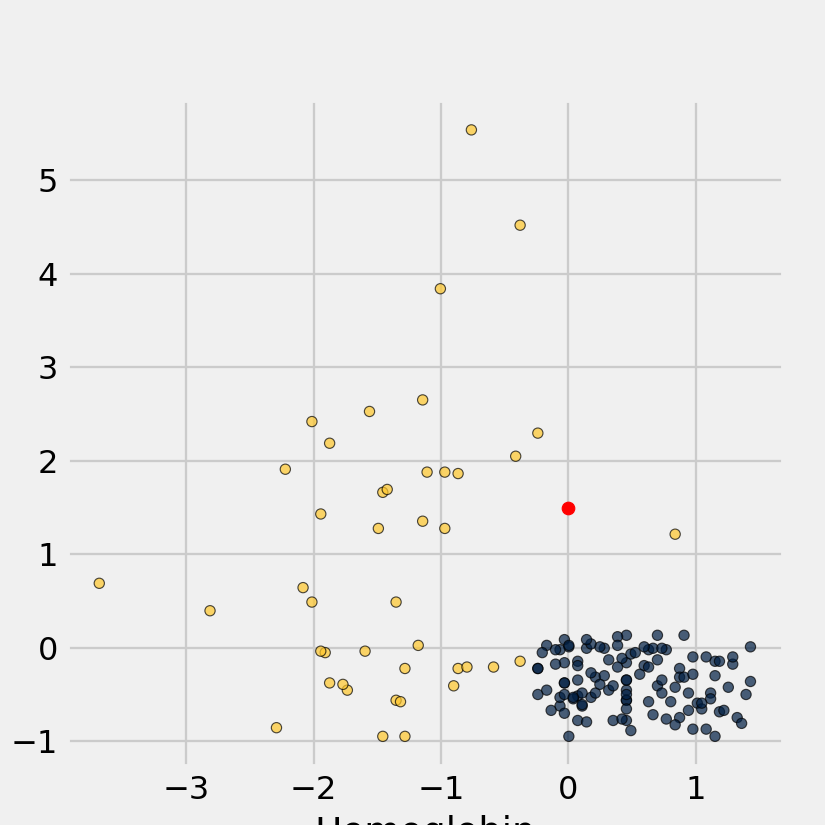

In [8]:
ckd.scatter('Hemoglobin','Glucose',colors='Class',edgecolor='k')
plots.scatter(0,1.5,color='r',s=30)

In [31]:
nearest = closest(ckd,['Hemoglobin','Glucose'],Alice,1)
nearest

Hemoglobin,Glucose,White Blood Cell Count,Class,Distance
-0.413266,2.04928,0.360623,1,0.687386


<IPython.core.display.Javascript object>


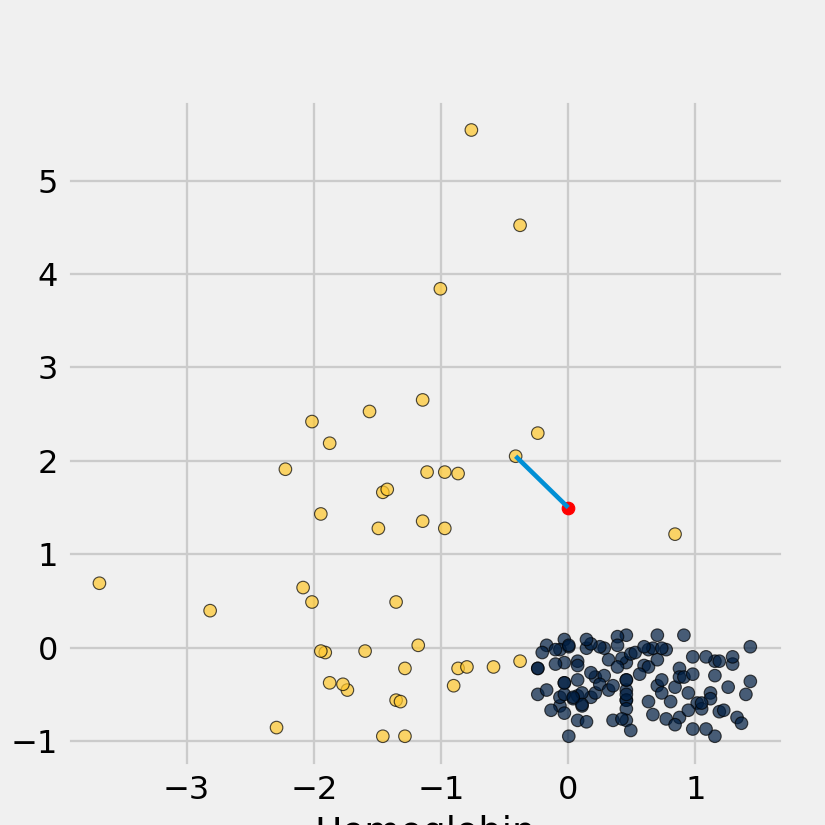

In [32]:
ckd.scatter('Hemoglobin','Glucose',colors='Class',s=30,edgecolor='k')
plots.scatter(0,1.5,color='r',s=30)

x_vals = [Alice[0],nearest.column('Hemoglobin').item(0)]
y_vals = [Alice[1],nearest.column('Glucose').item(0)]

plots.plot(x_vals,y_vals,lw=2)
plots.draw()

In [20]:
classify(ckd,['Hemoglobin','Glucose'],'Class',Alice)

1

In [34]:
x_vals = []
y_vals = []
class_vals = []

for x in np.arange(-4,2.25,0.1):
    for y in np.arange(-2,6.25,0.1):
        x_vals.append(x)
        y_vals.append(y)
        class_val = classify(ckd,['Hemoglobin','Glucose'],'Class',[x,y], 5)
        class_vals.append(class_val)
        
classes = Table().with_columns(
            'Hemoglobin',x_vals,
            'Glucose',y_vals,
            'Class',class_vals
            )





<IPython.core.display.Javascript object>


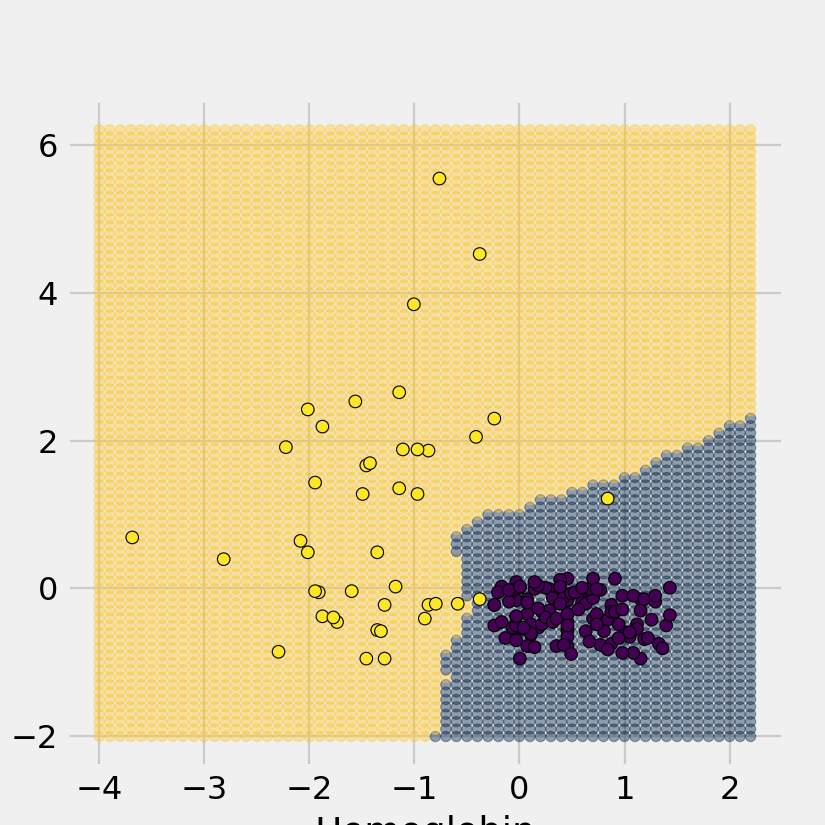

In [35]:
classes.scatter('Hemoglobin','Glucose',colors='Class',alpha=0.4)
plots.scatter(ckd.column('Hemoglobin'),ckd.column('Glucose'),c=ckd.column('Class'),edgecolor='k',s=30)

In [36]:
def row_classifier(a):
    return classify(ckd,['Hemoglobin','Glucose'],'Class',a,5)

ckd_with_pred = ckd.with_column(
        'Prediction', ckd.select(['Hemoglobin','Glucose']).apply(row_classifier)
        )
ckd_with_pred.show()

Hemoglobin,Glucose,White Blood Cell Count,Class,Prediction
-0.865744,-0.221549,-0.569768,1,1
-1.45745,-0.947597,1.16268,1,1
-1.00497,3.84123,-1.27558,1,1
-2.81488,0.396364,0.809777,1,1
-2.08395,0.643529,0.232293,1,1
-1.35303,-0.561402,-0.505603,1,1
-0.413266,2.04928,0.360623,1,1
-1.28342,-0.947597,3.34429,1,1
-1.10939,1.87936,-0.409356,1,1
-1.35303,0.489051,1.96475,1,1


In [37]:
true = ckd_with_pred.column('Class')
pred = ckd_with_pred.column('Prediction')
np.count_nonzero(true==pred)/len(true)

0.9873417721518988

In [38]:
shuffled_ckd = ckd.sample(with_replacement=False)
train_size = int(ckd.num_rows/2)
training = shuffled_ckd.take(range(train_size))
testing = shuffled_ckd.take(range(train_size,ckd.num_rows))

<IPython.core.display.Javascript object>


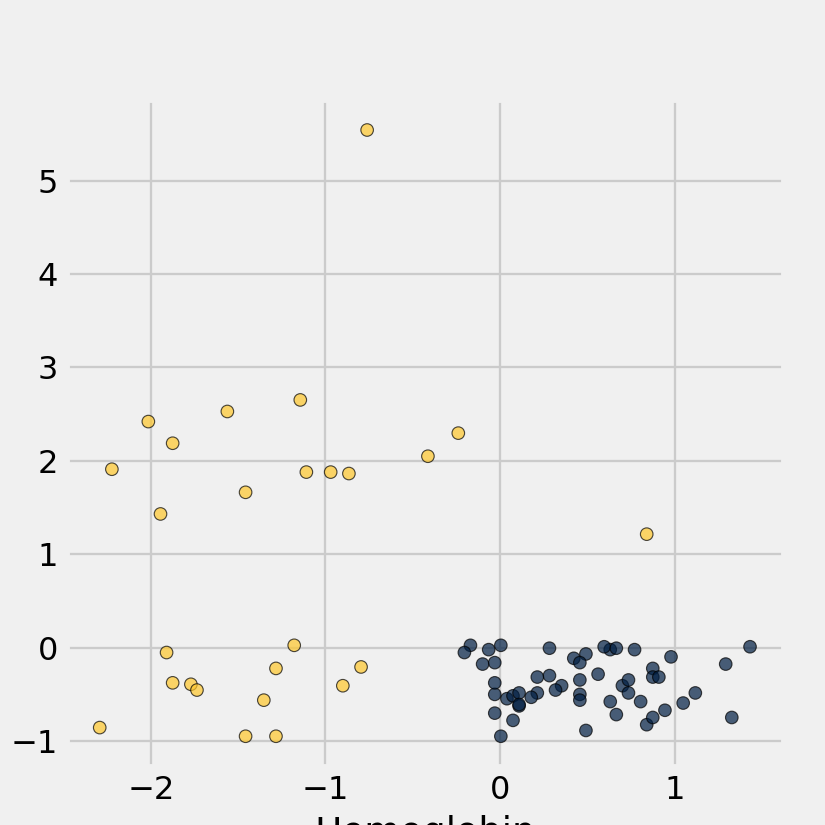

In [39]:
training.scatter('Hemoglobin','Glucose',colors='Class',s=30,edgecolor='k')


In [41]:
def new_classifier(a):
    return classify(training,['Hemoglobin','Glucose'],'Class',a,5)

In [42]:
tested = testing.with_column(
        'Prediction',testing.select(['Hemoglobin','Glucose']).apply(new_classifier)
        )
tested

Hemoglobin,Glucose,White Blood Cell Count,Class,Prediction
0.0392118,-0.530506,-0.666015,0,0
0.83975,-0.422371,-1.33975,0,0
-0.134818,-0.669536,-0.473521,0,0
1.04859,-0.654089,0.553118,0,0
0.178436,0.0410639,0.71353,0,0
-0.0304002,-0.376028,0.5852,0,0
-0.239236,-0.221549,-1.051,0,0
0.248048,0.0101682,-1.11517,0,0
0.14363,0.0874074,0.32854,0,0
1.25742,-0.422371,-0.0885313,0,0


In [43]:
true = tested.column('Class')
pred = tested.column('Prediction')
np.count_nonzero(true==pred)/len(true)

0.9746835443037974